In [1]:
import os
os.sys.path.append('../models')

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from EquiCtsConv import *
from EquiLinear import *

In [3]:
in_channels =21
layer_channels = [16,16,16,8]
num_radii = 3
num_theta = 16
reg_dim = 8
radius_scale = 40

In [4]:
firstlayer =  EquiCtsConv2dRho1ToReg(in_channels = in_channels, 
                                     out_channels = layer_channels[0],
                                     num_radii = num_radii, 
                                     num_theta = num_theta,
                                     radius = radius_scale, 
                                     k = reg_dim)

In [5]:
reg2regconv = EquiCtsConv2dRegToReg(in_channels = 16, 
                                         out_channels = 32,
                                         num_radii = num_radii, 
                                         num_theta = num_theta,
                                         radius = radius_scale, 
                                         k = reg_dim)

In [6]:
reg2rho1 = EquiCtsConv2dRegToRho1(in_channels = 16, 
                                     out_channels = 32,
                                     num_radii = num_radii, 
                                     num_theta = num_theta,
                                     radius = radius_scale, 
                                     k = reg_dim)

In [7]:
matlayer = EquiCtsConv2dRegToMat(in_channels = 16, 
                                     out_channels = 32,
                                     num_radii = num_radii, 
                                     num_theta = num_theta,
                                     radius = radius_scale, 
                                     k = reg_dim)

p torch.Size([1, 60, 2])
fluid_feats torch.Size([1, 60, 21, 2])
fluid_mask torch.Size([1, 60, 1])

In [8]:
p = torch.rand(1,60,2)
fl_feats = torch.rand([1, 60, 21, 2])
fluid_mask = torch.ones([1, 60, 1])


In [9]:
conv = firstlayer(p, p, fl_feats, fluid_mask)

In [10]:
conv.shape

torch.Size([1, 60, 16, 8])

In [11]:
activation = F.relu

In [12]:
feats = activation(conv)

In [13]:
feats.shape

torch.Size([1, 60, 16, 8])

In [14]:
# in: 16, out: 32
regconv = reg2regconv(p, p, feats, fluid_mask)

out, in, 4

In [15]:
rho1 = reg2rho1(p, p, feats, fluid_mask)

In [16]:
rho1.shape

torch.Size([1, 60, 32, 2])

In [17]:
matout = matlayer(p, p, feats, fluid_mask)

In [18]:
matout.shape

torch.Size([1, 60, 32, 2, 2])

in EquiCtsConv around line 100

InterpolateKernel(self, kernel, pos):

what does this do / mean? don't know how to deal with this for increased dimentions.

# Equivariance error

In [19]:
firstlayer =  EquiCtsConv2dRho1ToReg(in_channels = in_channels, 
                                     out_channels = layer_channels[0],
                                     num_radii = num_radii, 
                                     num_theta = num_theta,
                                     radius = radius_scale, 
                                     k = reg_dim)
reg2rho1 = EquiCtsConv2dRegToRho1(in_channels = 16, 
                                     out_channels = 1,
                                     num_radii = num_radii, 
                                     num_theta = num_theta,
                                     radius = radius_scale, 
                                     k = reg_dim)
matlayer = EquiCtsConv2dRegToMat(in_channels = 16, 
                                     out_channels = 1,
                                     num_radii = num_radii, 
                                     num_theta = num_theta,
                                     radius = radius_scale, 
                                     k = reg_dim)

In [20]:

p = torch.rand(1,60,2)
fl_feats = torch.rand([1, 60, 21, 2])
fluid_mask = torch.ones([1, 60, 1])

with torch.no_grad():
    conv = firstlayer(p, p, fl_feats, fluid_mask)
    feats = activation(conv)
    posout = reg2rho1(p, p, feats, fluid_mask)
    matout = matlayer(p, p, feats, fluid_mask)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

In [22]:
posout.shape, matout.shape

(torch.Size([1, 60, 1, 2]), torch.Size([1, 60, 1, 2, 2]))

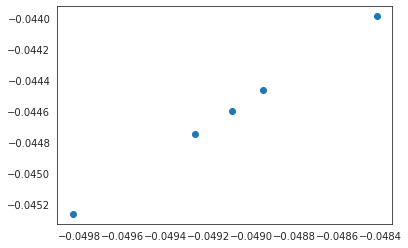

In [23]:
plt.scatter(posout[0,:5,0,0], posout[0,:5,0,1])

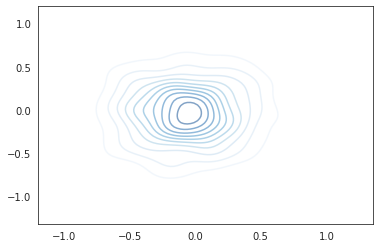

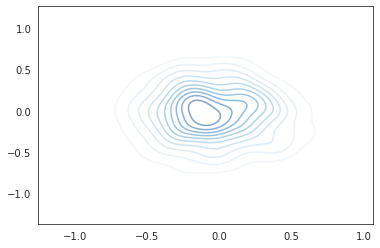

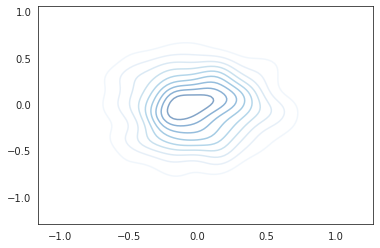

In [30]:
from train_utils import *

for i in range(3):
    sigma = calc_sigma_edit(matout[0,i,0,:,:])
    samples = np.random.multivariate_normal([posout[0,i,0,0], posout[0,i,0,1]], sigma, size=600)
    sns.kdeplot(data=samples, cmap="Blues", shade=False, alpha=0.5)
    plt.show()
    

In [27]:
p_rot = torch.tensor(rotation(0.5*np.pi, p), dtype = torch.float32)
feats_rot = torch.tensor(rotation(0.5*np.pi, fl_feats), dtype = torch.float32)

In [28]:
with torch.no_grad():
    conv = firstlayer(p_rot, p_rot, feats_rot, fluid_mask)
    feats = activation(conv)
    posout_rot = reg2rho1(p_rot, p_rot, feats, fluid_mask)
    matout_rot = matlayer(p_rot, p_rot, feats, fluid_mask)

Why does this matter?

- add the equivariance test to paper
- Add matrix setup for write up
- update results w/ full equivariance
- cheating test?
    - rotate all the data and see if 
    - test on unseen cities? 

- polynomial / exponential scaling?
- function of the dot product w/ past trajectories 
- angle and magnitude instead of absolute velocity vectors

(graph network) anisotrphic graph convolution (position is feature vector)

In [44]:
for i in range(12):
    sigma1 = calc_sigma_edit(matout[0,i,0,:,:])
    p = torch.distributions.MultivariateNormal(posout[0,i,0,:],sigma1)
    
    pos_rot_back = torch.tensor(rotation(-0.5* np.pi, posout_rot), dtype = torch.float32)
    sigma2 = calc_sigma_edit(matout_rot[0,i,0,:,:])
    sigma2_rot_back = rot_cov(-0.5* np.pi, sigma2)
    q = torch.distributions.MultivariateNormal(pos_rot_back[0,i,0,:], sigma2_rot_back)
    
    kl = torch.distributions.kl.kl_divergence(p, q)
    print(kl)
    

    # what if we don't rotate back
    j = torch.distributions.MultivariateNormal(pos_rot_back[0,i,0,:], sigma2)
    kl_compare = torch.distributions.kl.kl_divergence(p, j)
    print(kl_compare)



tensor(0.)
tensor(0.0018)
tensor(0.)
tensor(0.0019)
tensor(0.)
tensor(0.0018)
tensor(0.)
tensor(0.0018)
tensor(0.)
tensor(0.0018)
tensor(0.)
tensor(0.0018)
tensor(0.)
tensor(0.0018)
tensor(0.)
tensor(0.0018)
tensor(0.)
tensor(0.0018)
tensor(0.)
tensor(0.0019)
tensor(0.)
tensor(0.0017)
tensor(0.)
tensor(0.0018)


In [32]:
def RotMat(theta):
    m = np.array([
            [np.cos(theta), -np.sin(theta)], 
            [np.sin(theta), np.cos(theta)]
        ])
    return m

def rotation(theta, field):
    rotmat = RotMat(theta)
    rot_field = np.zeros(field.shape)
    rot_field[...,:2] =  np.einsum('ij,...j->...i', rotmat, field[...,:2])
    if field.shape[-1] > 2:
        rot_field[...,2] = 0
    return rot_field

def rotate_pred(data, theta):
    xy = data[:,:,:2]
    cov = data[:,:,-4:].reshape(*data.shape[:2],2,2)

    new_xy =  torch.tensor(rotation(theta, xy), dtype=torch.float32) 
    rot = torch.tensor(RotMat(theta), dtype=torch.float32) 
    new_cov = rot@cov@rot.T
    #new_cov = torch.matmul(torch.matmul(rot, cov), rot.T)
    return new_xy, new_cov

def rot_cov(theta, cov):
    rot = torch.tensor(RotMat(theta), dtype=torch.float32) 
    new_cov = rot@cov@rot.T
    return new_cov